<a href="https://colab.research.google.com/github/changhoonhahn/gqp_mc/blob/master/nb/dPCA_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
%cd /content/drive/My\ Drive/speculator_fork

/content/drive/.shortcut-targets-by-id/1mXOA5v3haTos5p9R5pMbAORSsvd9WFLa/speculator_fork


In [52]:
import os 
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
import seaborn as sns
from speculator import SpectrumPCA
from speculator import Speculator
sns.set_theme(context = 'talk', style = 'ticks')
from tqdm import tqdm

In [53]:
def frac_plot(n_pcas,dust,batches,jump=1,save=False):
    '''
    ----------------------------------------------------------------------
    parameter | n_pcas  | number of PCA components
    parameter | dust    | dust model
    parameter | batches | number of batches
    parameter | jump    | step size when interating over the samples 
    parameter | save    | if true, save the plot
    ----------------------------------------------------------------------
    '''

    if dust == 'simpledust':
        n_param = 8
    elif dust == 'complexdust':
        n_param = 10
    else:
        raise ValueError('dust should be either simpledust or complexdust')
    
    n_wave  = len(wave)
    n_batch = int(batches.split('_')[1])+1
    theta_test = np.load(f'DESI_{dust}.theta_test.npy')
    num_sample = theta_test.shape[0]
   
    '''
    ----------------------------------------------------------------------
    Load Speculator and predict PCA coefficients
    ----------------------------------------------------------------------
    '''
    speculator = Speculator(restore=True, restore_filename=f'_james_DESI_{dust}_model.%s.pca%i.log' % (batches, n_pcas))
    spec_pca = speculator.call(theta_test.astype(np.float32))


    '''
    ----------------------------------------------------------------------
    Compute PCA coefficients
    ----------------------------------------------------------------------
    '''
    print('Training PCA bases') 
    PCABasis = SpectrumPCA(
            n_parameters=n_param,       # number of parameters
            n_wavelengths=n_wave,       # number of wavelength values
            n_pcas=n_pcas,              # number of pca coefficients to include in the basis 
            spectrum_filenames=[f'DESI_{dust}.logspectrum_fsps_test.npy'],  # list of filenames containing the (un-normalized) log spectra for training the PCA
            parameter_filenames=[f'DESI_{dust}.theta_test.npy'], # list of filenames containing the corresponding parameter values
            parameter_selection=None) # pass an optional function that takes in parameter vector(s) and returns True/False for any extra parameter cuts we want to impose on the training sample (eg we may want to restrict the parameter ranges)
    PCABasis._load_from_file(f'DESI_{dust}.%s.seed0.pca%i.hdf5' % (batches, n_pcas))

    spectra = np.load(f'DESI_{dust}.logspectrum_fsps_test.npy')
    PCABasis.compute_spectrum_parameters_shift_and_scale()
    normalized_spectra = (spectra - PCABasis.spectrum_shift)/PCABasis.spectrum_scale
    fit = PCABasis.PCA.fit(normalized_spectra)
    true_pca = PCABasis.PCA.transform(normalized_spectra)
    
    
    '''
    ----------------------------------------------------------------------
    Compute fractional error
    ----------------------------------------------------------------------
    '''
    frac_err = []
    for n in tqdm(range(num_sample//jump)):
        frac_err.append((spec_pca[n]-true_pca[n])/true_pca[n])

    lll = np.percentile(frac_err, 0.1, axis=0)
    hhh = np.percentile(frac_err, 99.9, axis=0)
    ll = np.percentile(frac_err, 1, axis=0)
    hh = np.percentile(frac_err, 99, axis=0)
    h = np.percentile(frac_err, 95, axis=0)
    l = np.percentile(frac_err, 5, axis=0)
    
    '''
    ----------------------------------------------------------------------
    Plot
    ----------------------------------------------------------------------
    '''
    fig, axs = plt.subplots(1,2,figsize=(40,10), sharex=True)
    plt.subplots_adjust(wspace=.08)
    x= np.arange(n_pcas)+1

    axs[0].bar(x,lll, color = 'C0', alpha = 0.2, label ='99.9%')
    axs[0].bar(x,hhh, color = 'C0', alpha = 0.2)
    axs[0].bar(x,ll, color = 'C0', alpha = 0.2)
    axs[0].bar(x,hh, color = 'C0', alpha = 0.2, label = '99%')
    axs[0].bar(x,l, color = 'C0', alpha = 0.4)
    axs[0].bar(x,h, color = 'C0', alpha = 0.4, label = '95%')

    axs[1].bar(x,lll, color = 'C0', alpha = 0.2, label ='99.9%')
    axs[1].bar(x,hhh, color = 'C0', alpha = 0.2)
    axs[1].bar(x,ll, color = 'C0', alpha = 0.2)
    axs[1].bar(x,hh, color = 'C0', alpha = 0.2, label = '99%')
    axs[1].bar(x,l, color = 'C0', alpha = 0.4)
    axs[1].bar(x,h, color = 'C0', alpha = 0.4, label = '95%')

    axs[0].axhline(0, ls = '--', lw = 1, c ='k')
    axs[1].axhline(0, ls = '--', lw = 1, c ='k')

    axs[0].set_ylim(-50,50)
    axs[0].set_xticks(x)
    axs[0].set_xticklabels((x).astype(str))

    ax= fig.add_axes([.95,0,0,0.88],)
    ax.bar([1,1],[1,1], color = 'C0', alpha = 0.6, label = '95%')
    ax.bar([1,1],[1,1], color = 'C0', alpha = 0.4, label = '99%')
    ax.bar([1,1],[1,1], color = 'C0', alpha = 0.2, label = '99.9%')
    ax.axis('off')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.legend()

    fig.suptitle('PCA coefficent fractional error\n%s | $N_{PCA}=$%i | $N_{Batch}=$%i'%(dust,n_pcas,n_batch))
    axs[0].set_ylabel('Fractional error')
    axs[0].set_xlabel('PCA coefficient index')
    axs[1].set_xlabel('PCA coefficient index')

    if save:
        fig.savefig(f'{dust}.pca_{n_pcas}.batch_{batches}.dfrac.pdf', format = 'pdf', bbox_inches='tight')
    plt.show()
    plt.close()

    return None


Training PCA bases


100%|██████████| 10000/10000 [00:04<00:00, 2063.98it/s]


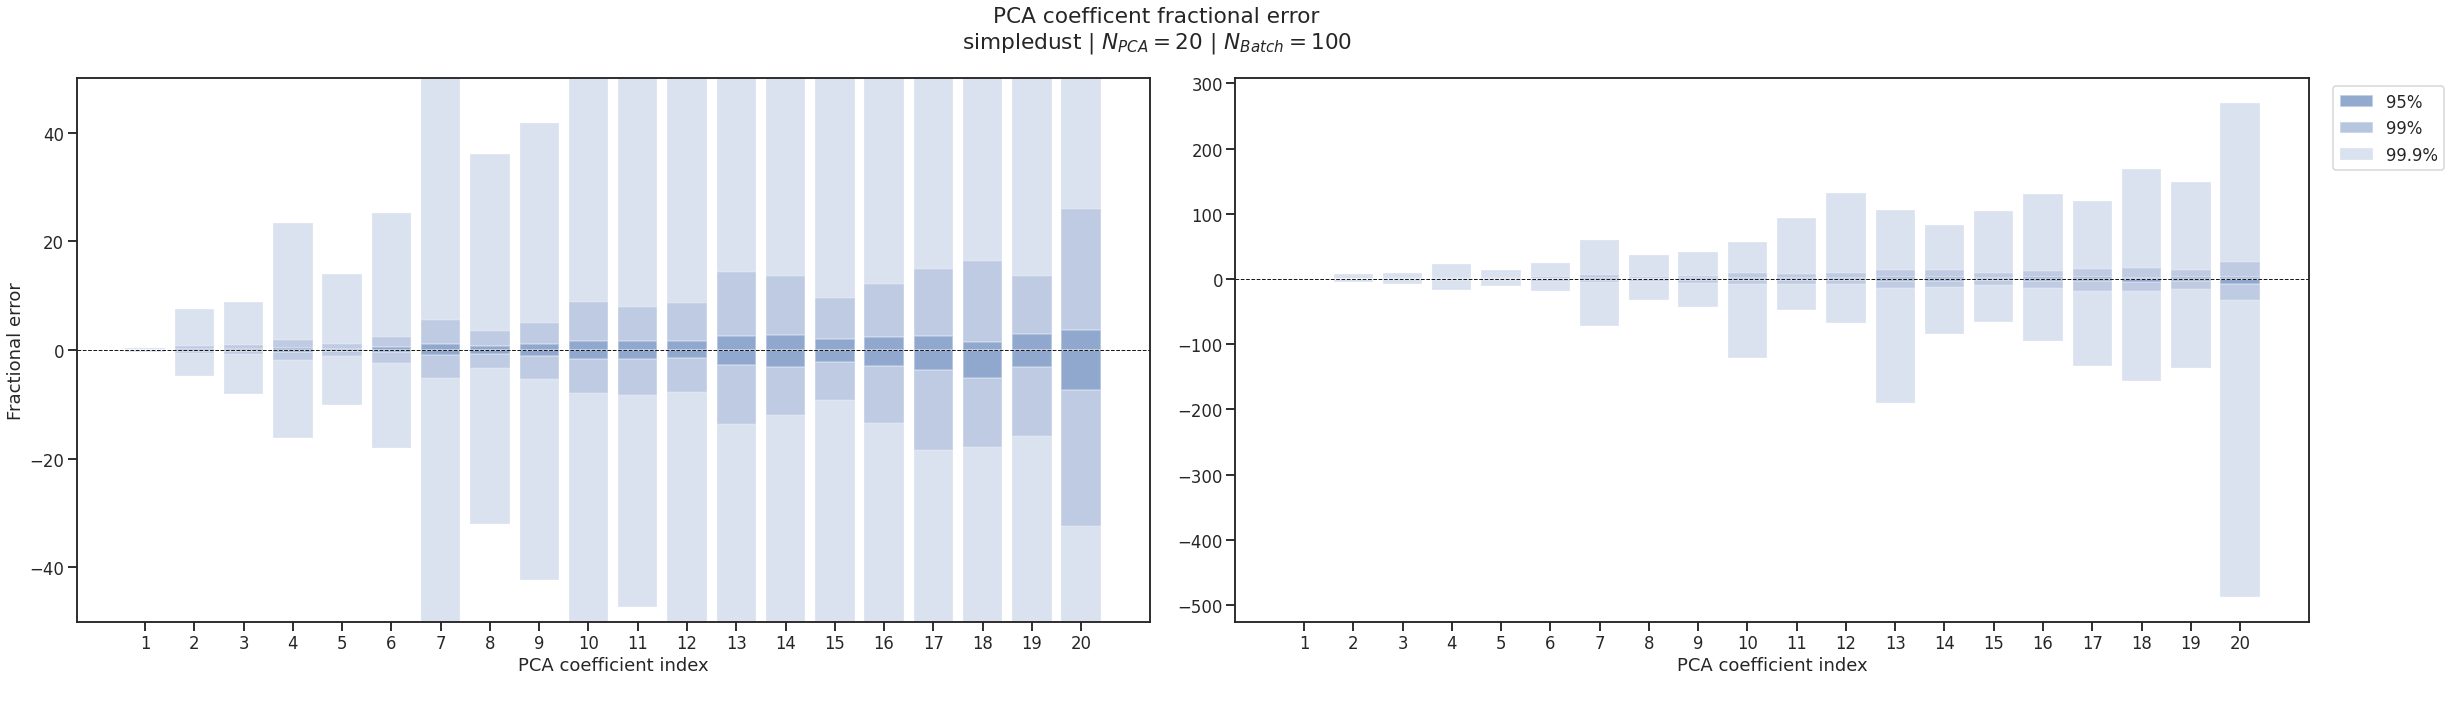

Training PCA bases


100%|██████████| 10000/10000 [00:06<00:00, 1526.33it/s]


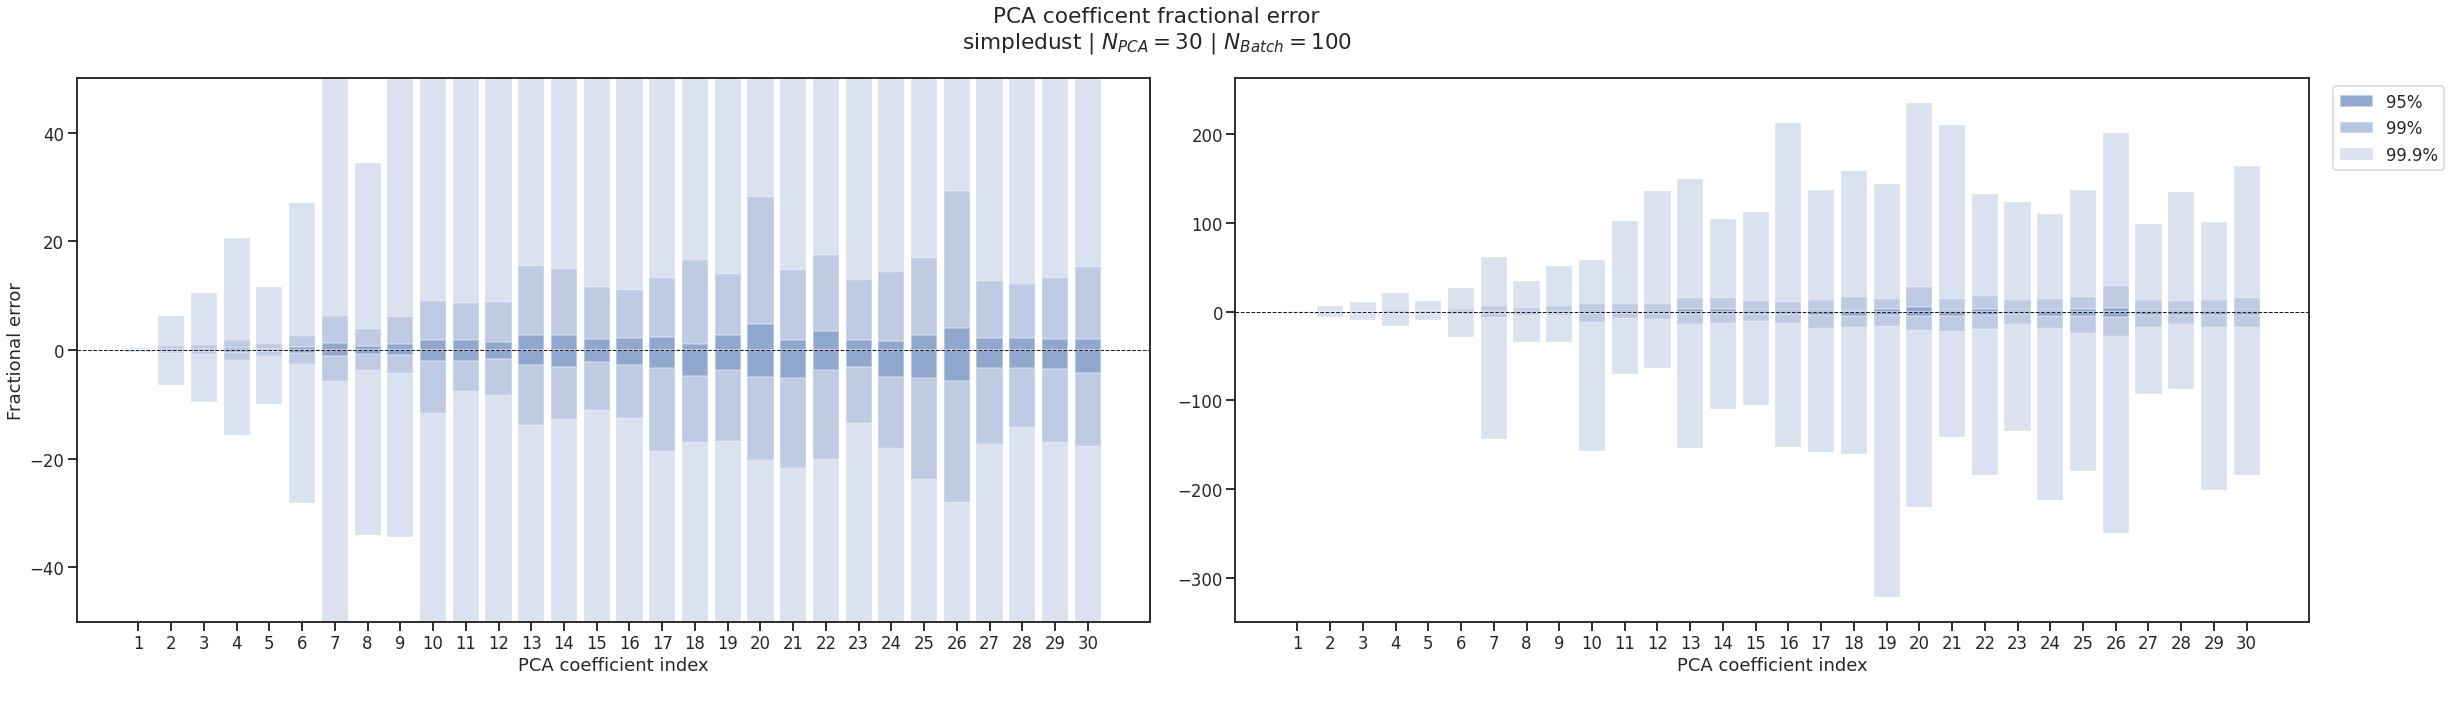

Training PCA bases


100%|██████████| 10000/10000 [00:04<00:00, 2114.35it/s]


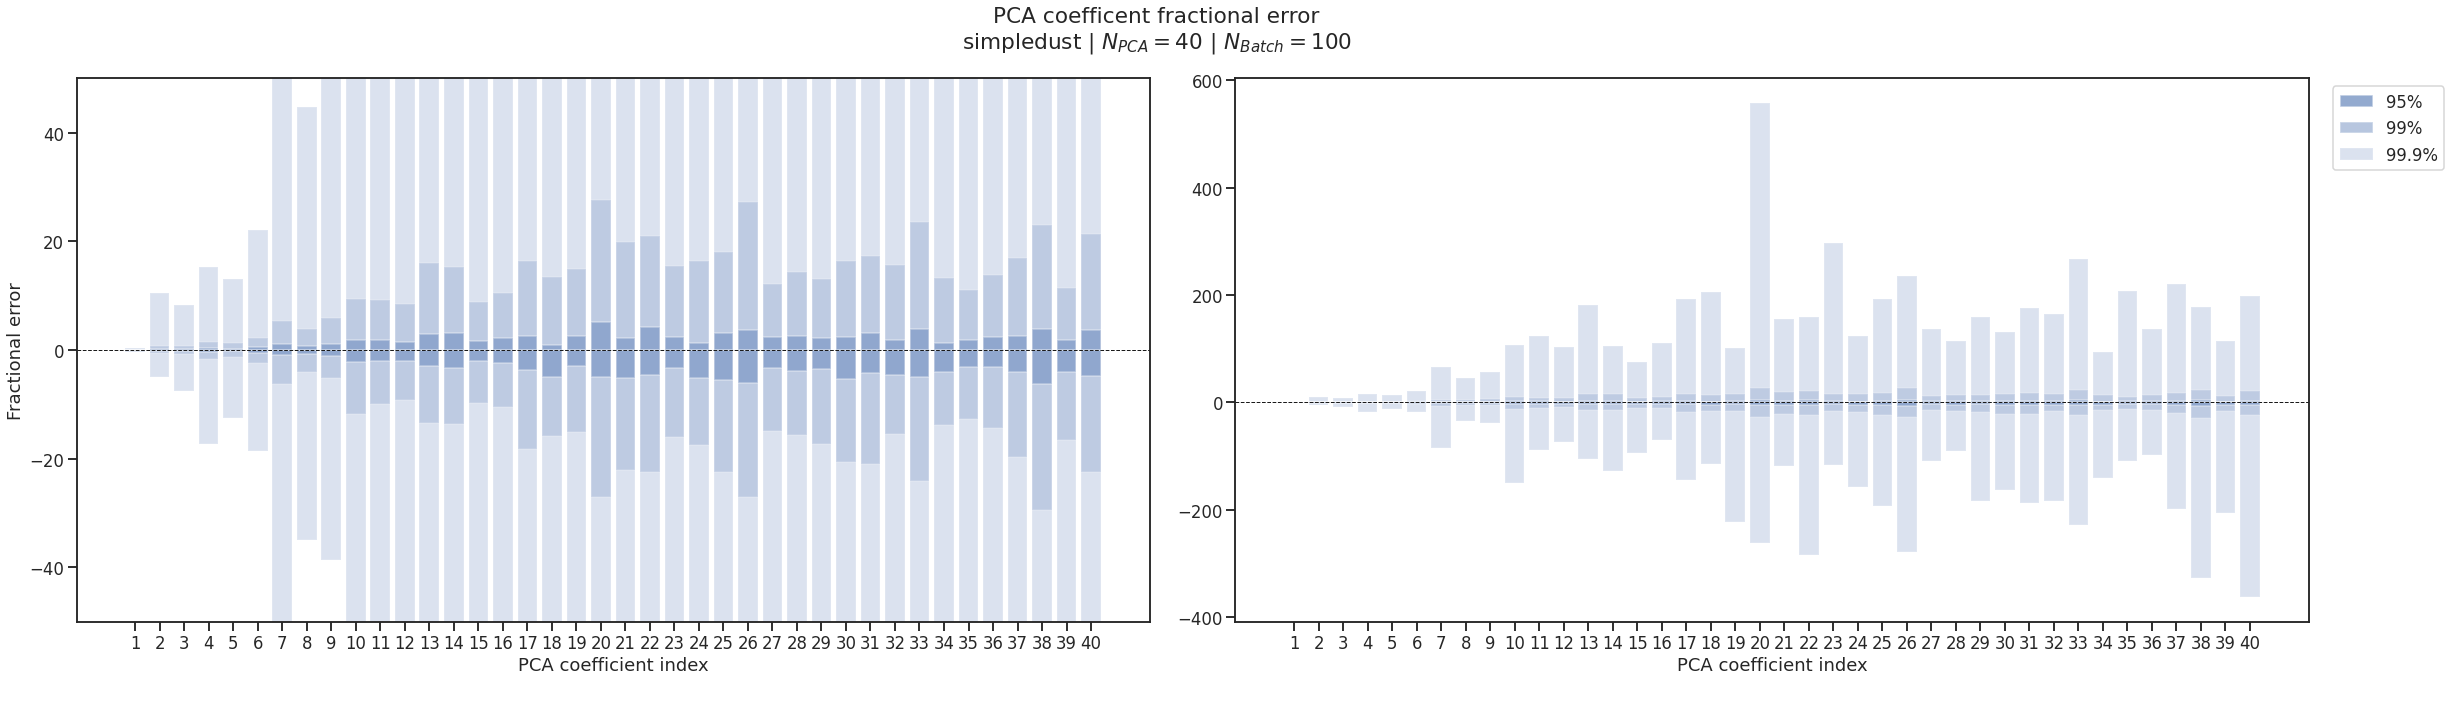

In [ ]:
frac_plot(20,'simpledust','0_99',save=False)
frac_plot(30,'simpledust','0_99',save=True)
frac_plot(40,'simpledust','0_99',save=True)

Training PCA bases


100%|██████████| 10000/10000 [00:04<00:00, 2068.34it/s]


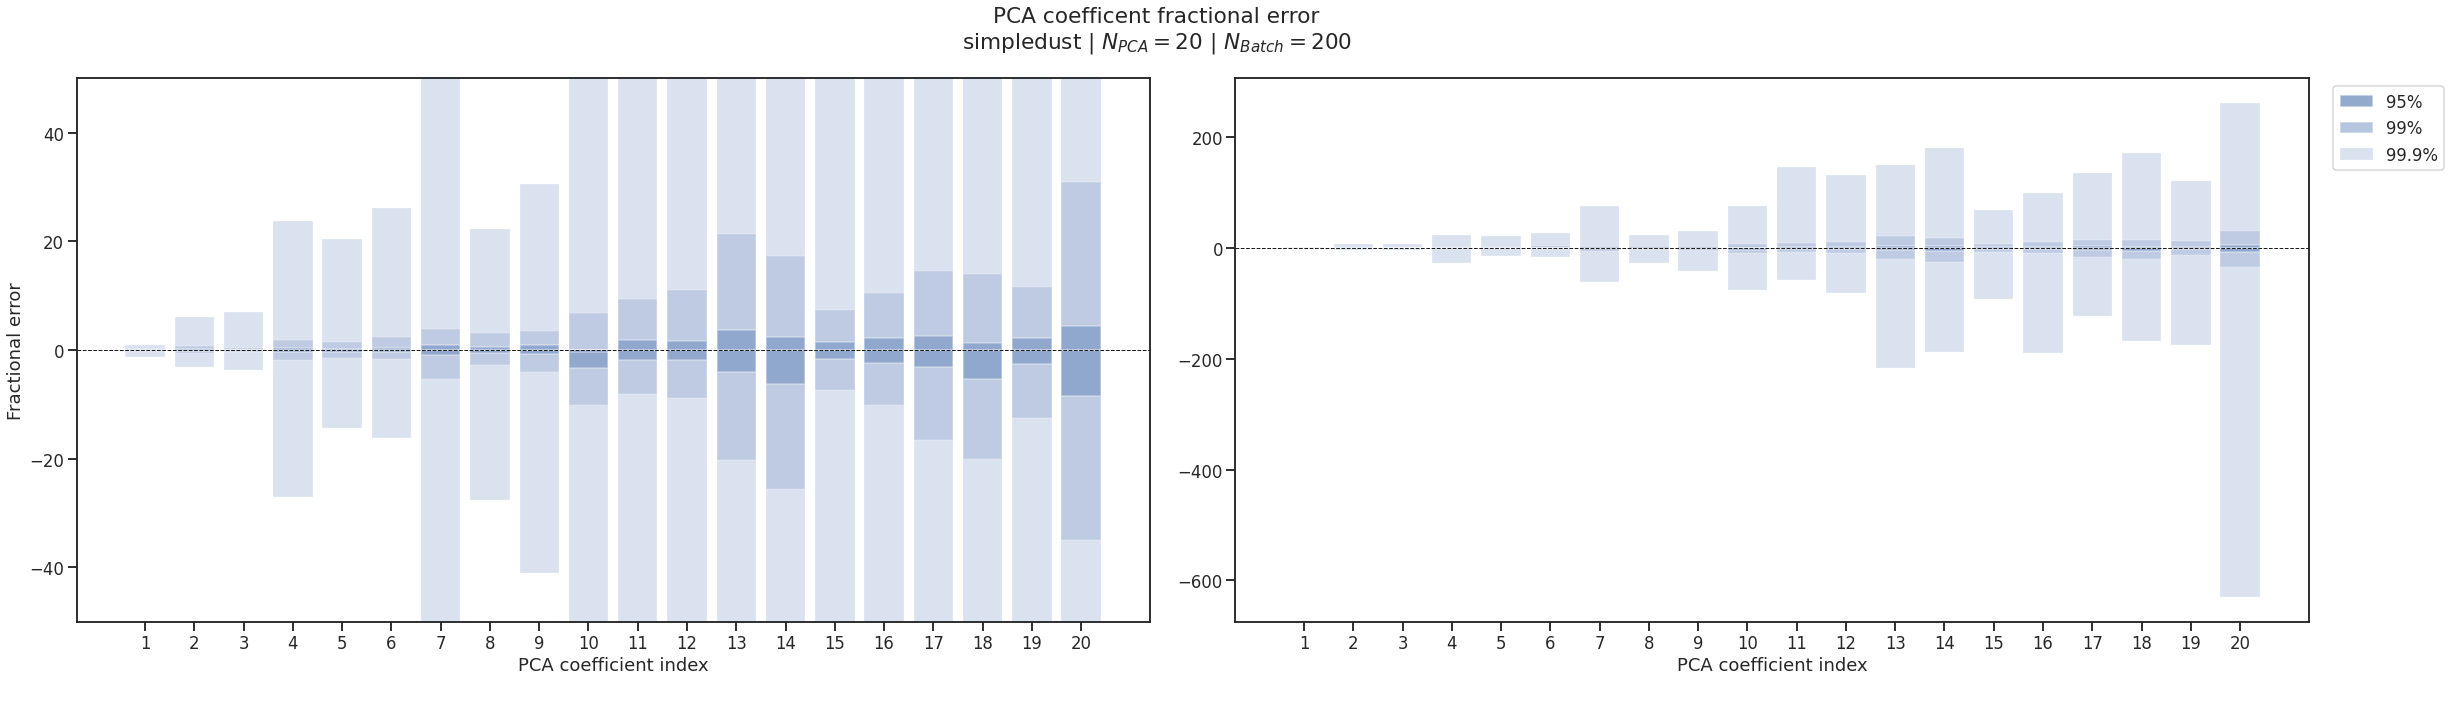

Training PCA bases


100%|██████████| 10000/10000 [00:04<00:00, 2008.37it/s]


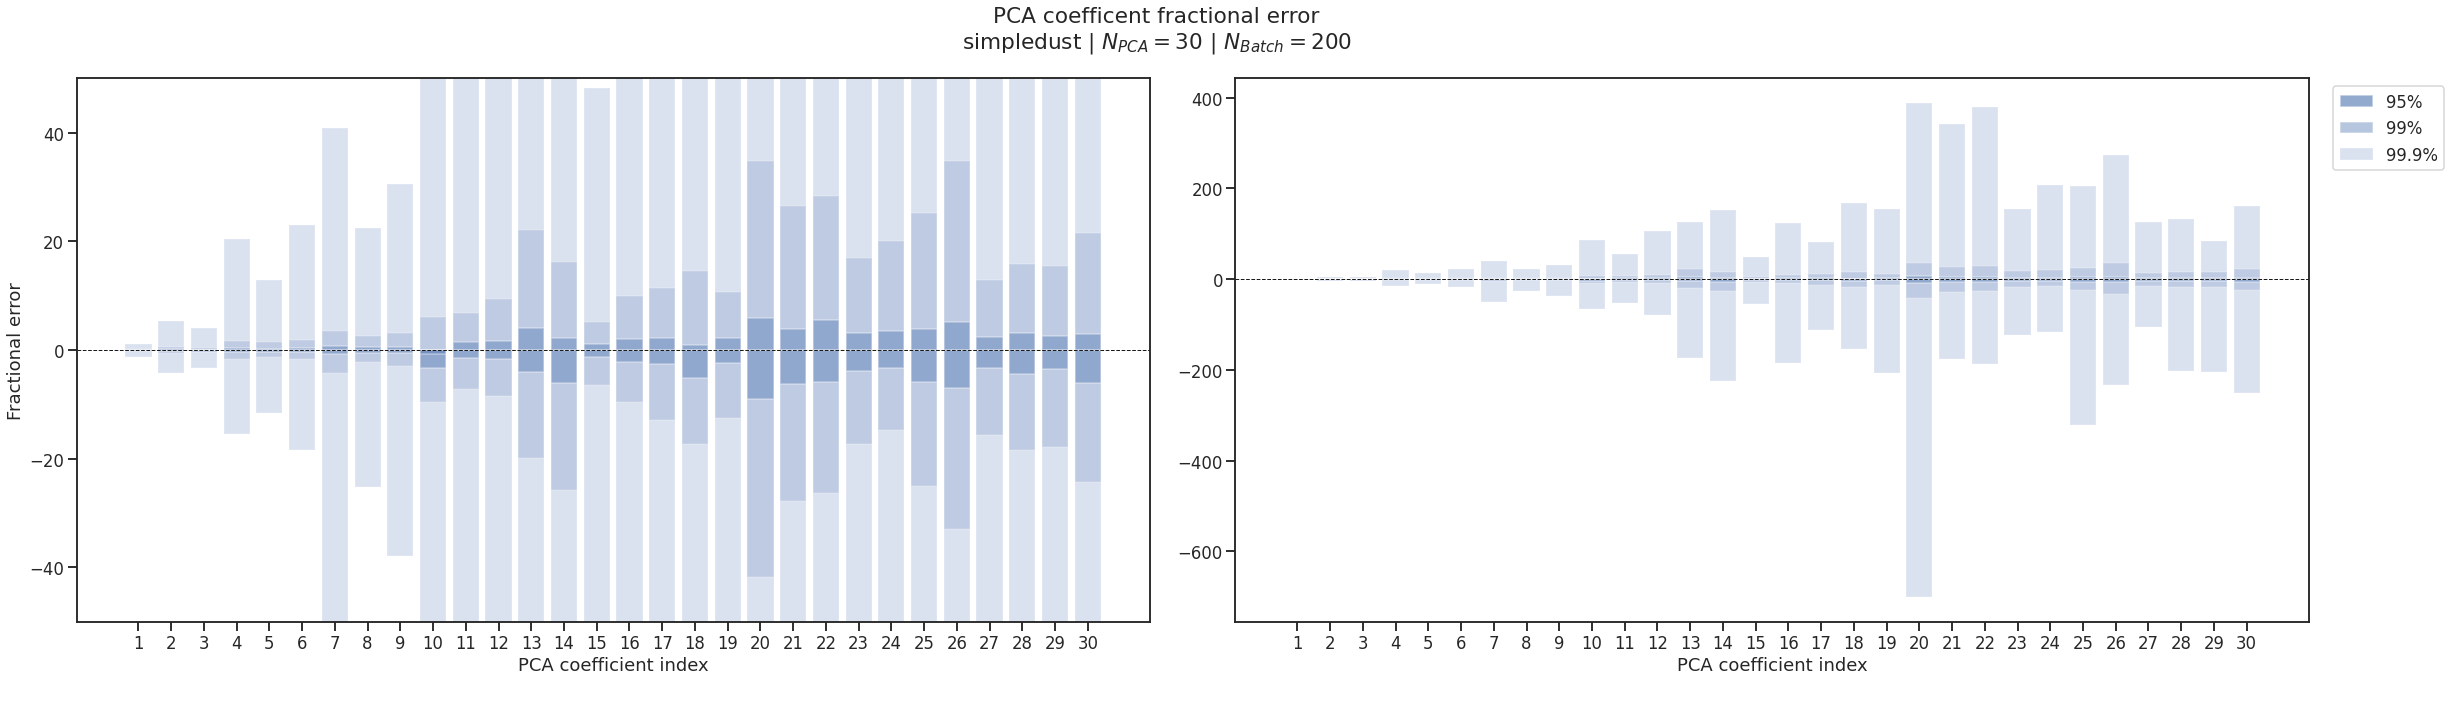

FileNotFoundError: ignored

In [ ]:
frac_plot(20,'simpledust','0_199',save=True)
frac_plot(30,'simpledust','0_199',save=True)
frac_plot(40,'simpledust','0_199',save=True)

Training PCA bases


100%|██████████| 10000/10000 [00:04<00:00, 2043.72it/s]


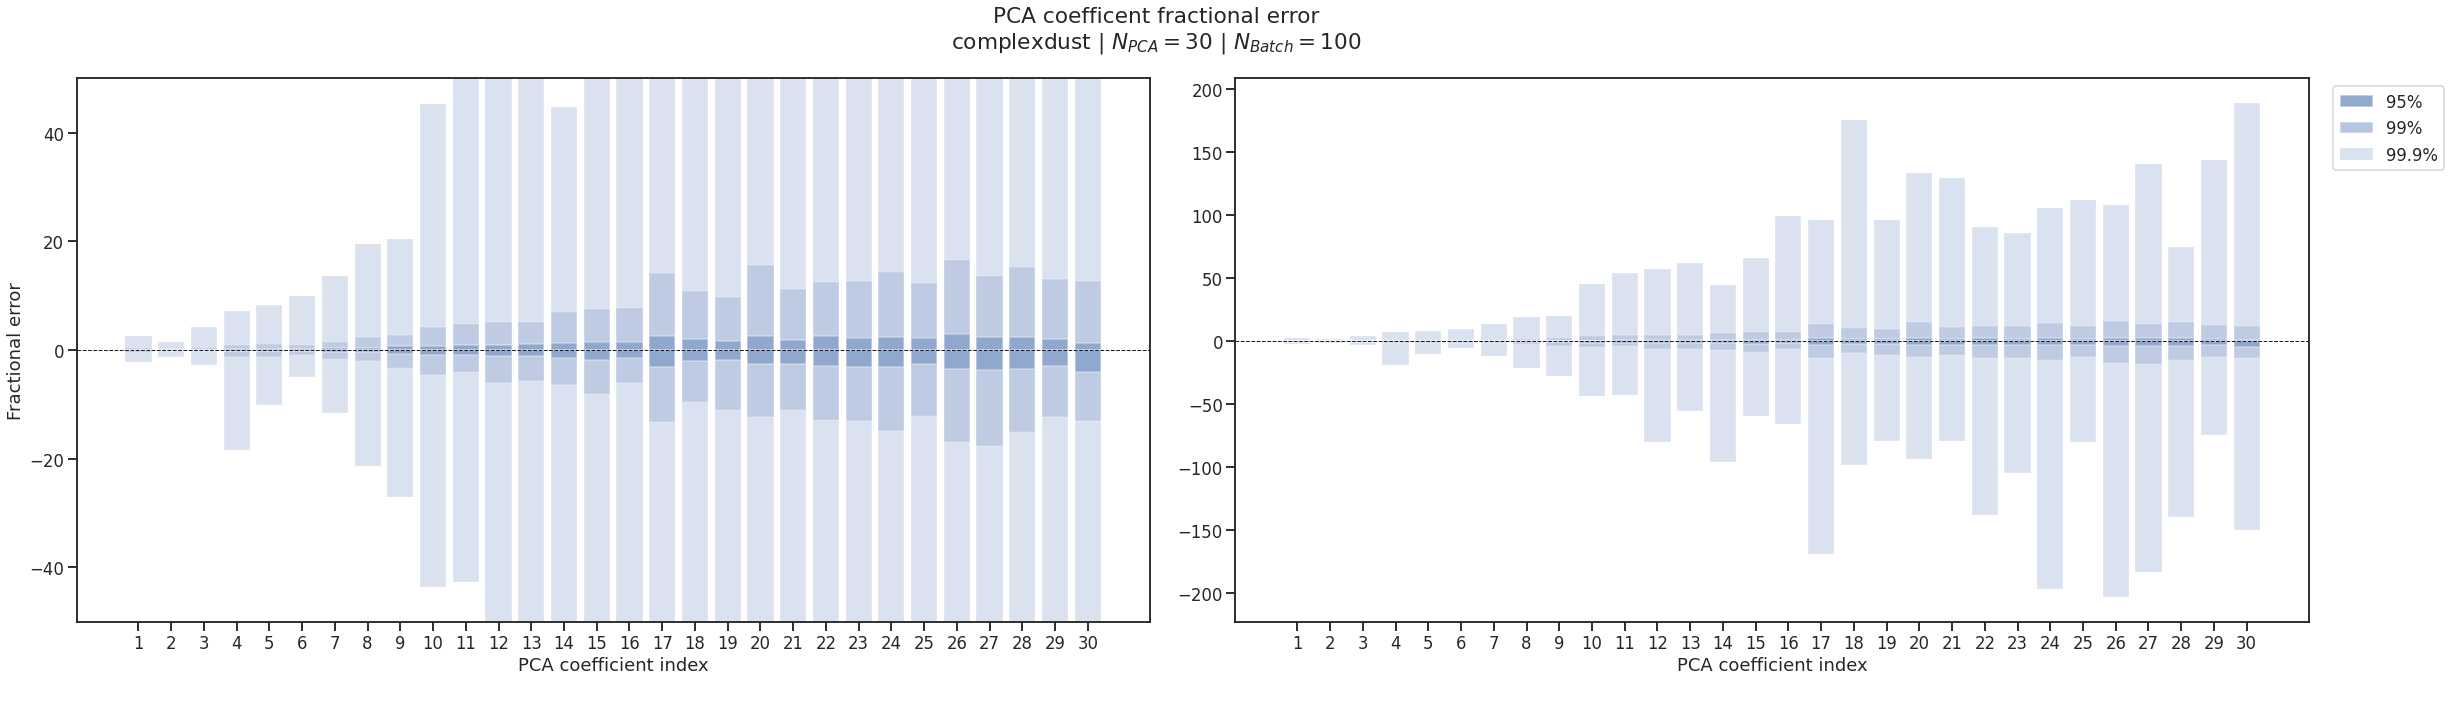

Training PCA bases


100%|██████████| 10000/10000 [00:04<00:00, 2053.53it/s]


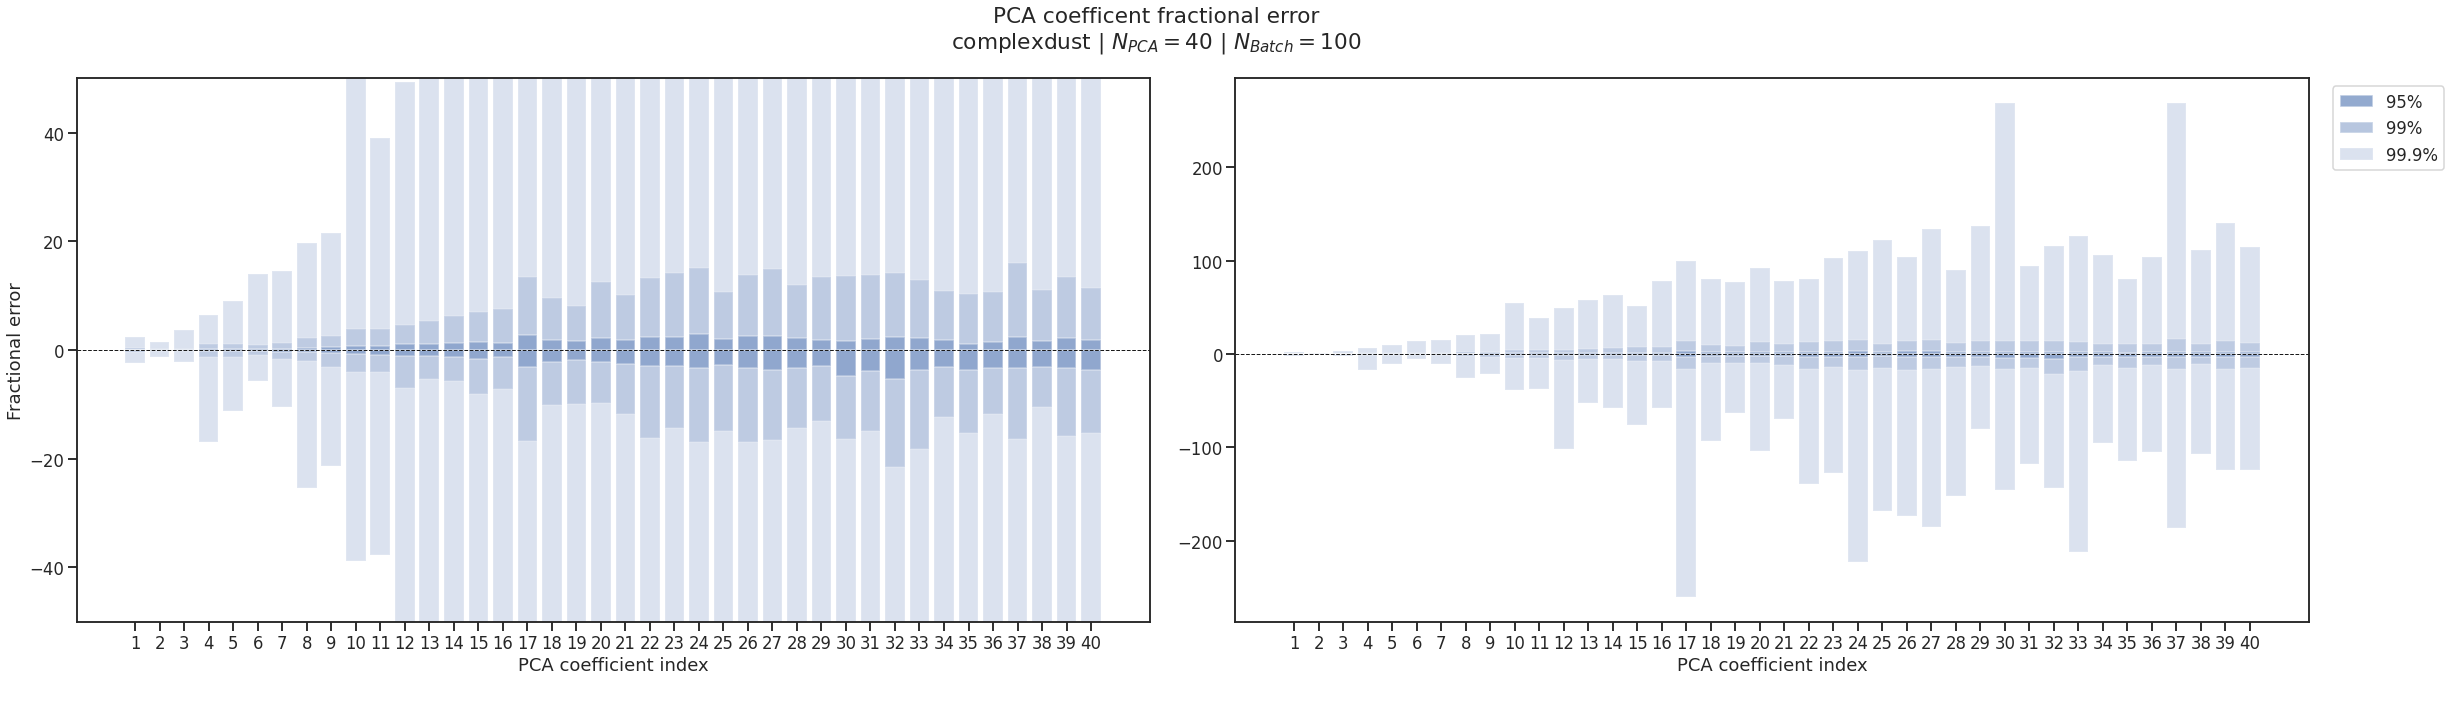

Training PCA bases


100%|██████████| 10000/10000 [00:05<00:00, 1987.56it/s]


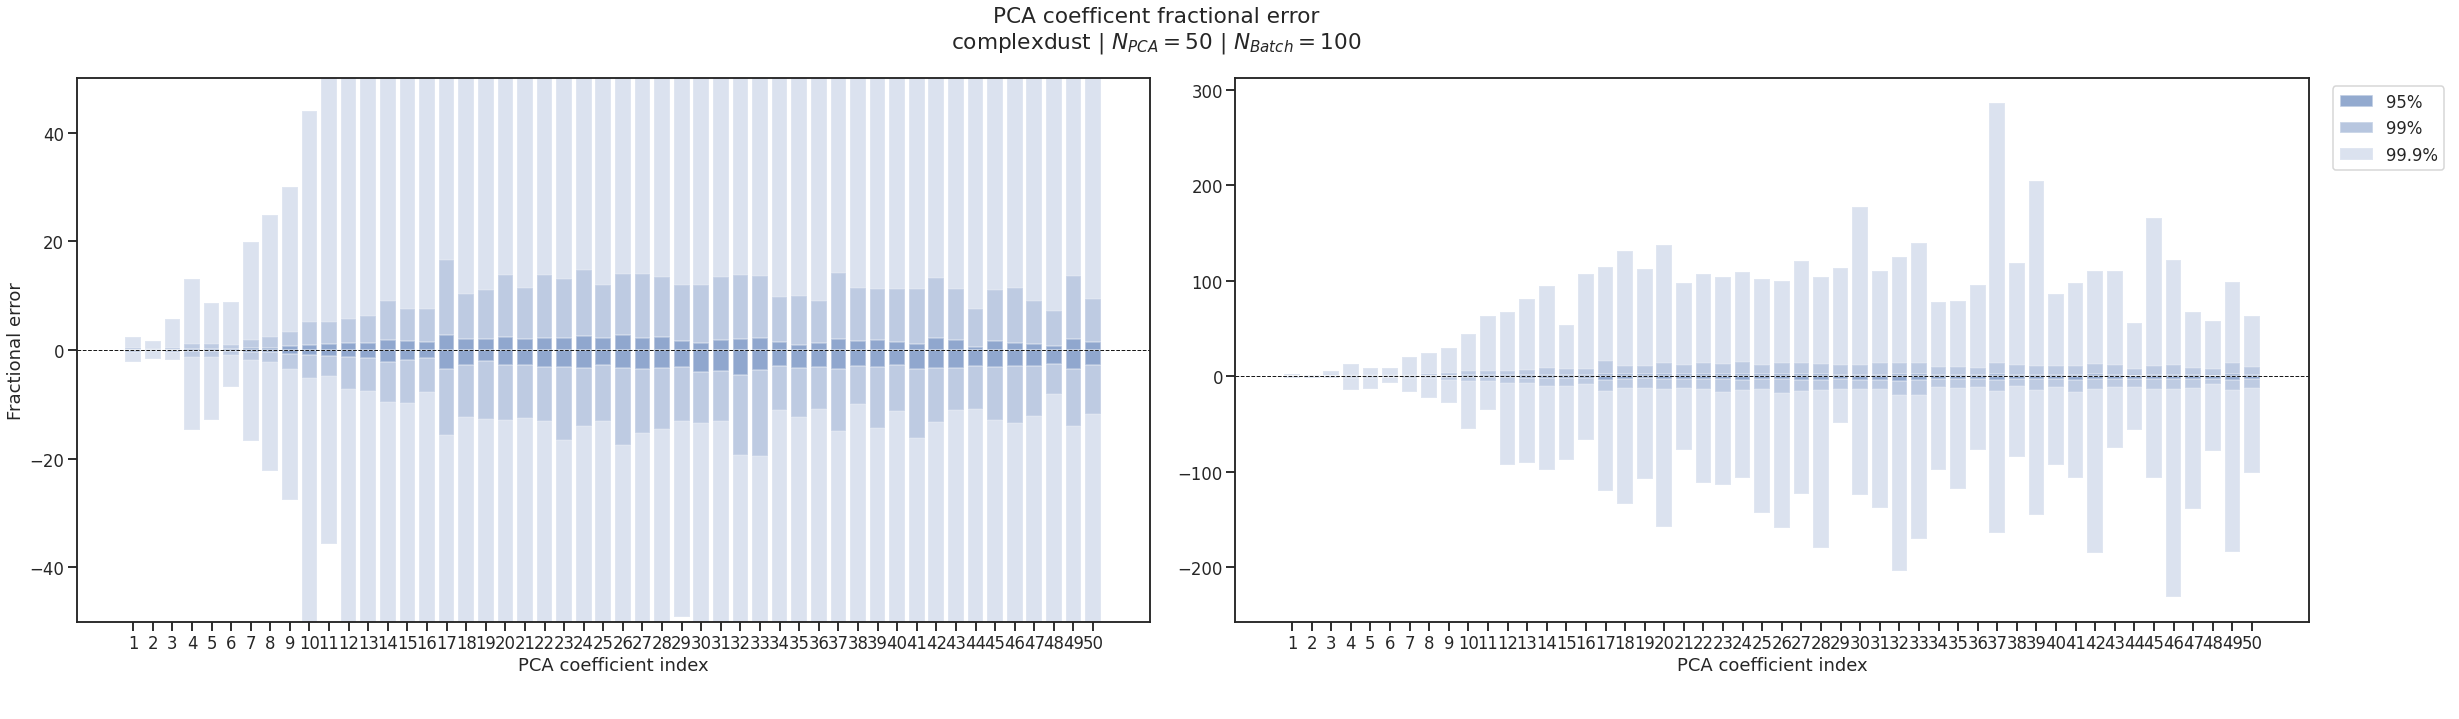

FileNotFoundError: ignored

In [54]:
frac_plot(30,'complexdust','0_99',save=True)
frac_plot(40,'complexdust','0_99',save=True)
frac_plot(50,'complexdust','0_99',save=True)
frac_plot(60,'complexdust','0_99',save=True)